In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, GeometryCollection
import h5py


# OP2: Long-horizon path planning in Douro river mouth.

## Stage I: get operational area and origin. 

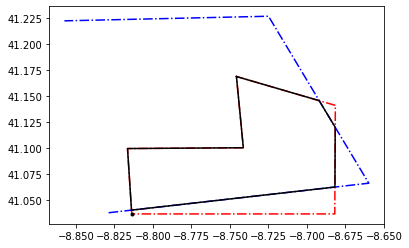

In [26]:
def vectorise(v):
    return np.array(v).reshape(-1, 1)

# s1: load allowed region
path = "OperationArea.csv"
plg_allowed = pd.read_csv(path).to_numpy()

# s2: load delft3d data area
plg_delft3d = np.array([[41.0382, -8.8287],
                        [41.0665, -8.6598],
                        [41.2265, -8.7249],
                        [41.2221, -8.8574]])

# s3: get intersected operational area
ins = []
ins.append(Polygon(plg_allowed).intersection(Polygon(plg_delft3d)))
opr = GeometryCollection(ins)
opa = opr.geoms
lat_op = vectorise(opa[0].exterior.xy[0])
lon_op = vectorise(opa[0].exterior.xy[1])
plg_op = np.hstack((lat_op, lon_op))


plt.plot(plg_allowed[:, 1], plg_allowed[:, 0], 'r-.')
plt.plot(plg_allowed[-3, 1], plg_allowed[-3, 0], 'k.')
plt.plot(plg_delft3d[:, 1], plg_delft3d[:, 0], 'b-.')
plt.plot(plg_op[:, 1], plg_op[:, 0], 'k-')

# s4: save op to file
df = pd.DataFrame(plg_op, columns=['lat', 'lon'])
df.to_csv("OPA_GOOGLE.csv", index=False)

## TODO: filter data from the surface of Delft3D for that polygon, then set up variogram and coefficients and then determine the A* or PRM or RRT* and finish the system. Do Simulation and HITL. Then launch the mission. 